In [1]:
%matplotlib widget
import math
from kan import *
torch.set_default_dtype(torch.float32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Parameters
input_size = 1
hidden_layers = 5#10
output_size = 1
epochs = 50
learning_rate = 0.001
variance = 0.02
train_samples = 1000
test_samples = 1000
interval = (0, 2*torch.pi)

cpu


In [ ]:
from kan.utils import create_dataset

def add_white_noise(x_train, mean=0.0, variance=0.01):
    """
    Adds white noise to the input data.

    Args:
        x_train (torch.Tensor): The input training data (e.g., x_train).
        mean (float): Mean of the Gaussian noise to be added.
        variance (float): Variance of the Gaussian noise to be added.

    Returns:
        torch.Tensor: The noisy data.
    """
    # Generate Gaussian noise (mean, variance) with the same shape as x_train
    noise = torch.normal(mean=mean, std=torch.sqrt(torch.tensor(variance)), size=x_train.size())
    
    # Add noise to the original training data
    noisy_data = x_train + noise

    return noisy_data


# create dataset f(x,y) = sin(x)
f = lambda x: torch.sin(x[:,[0]])
#dataset = create_dataset(f, n_var=2, device=device, normalize_input=True, normalize_label=True, train_num=1000, test_num=1000)
dataset = create_dataset(
    f, 
    n_var=1, 
    device=device, 
    normalize_input=False, 
    normalize_label=False, 
    train_num=train_samples, 
    test_num=test_samples,
    ranges=[interval[0], interval[1]],
)

# Use torch.linspace for direct PyTorch tensor creation
x = torch.linspace(interval[0], interval[1], train_samples)
x = torch.stack([x.ravel()], dim=-1)
y = add_white_noise(f(x), 0.0, variance)
dataset['train_input'] = x
dataset['train_label'] = y
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

checkpoint directory created: ./model
saving model version 0.0


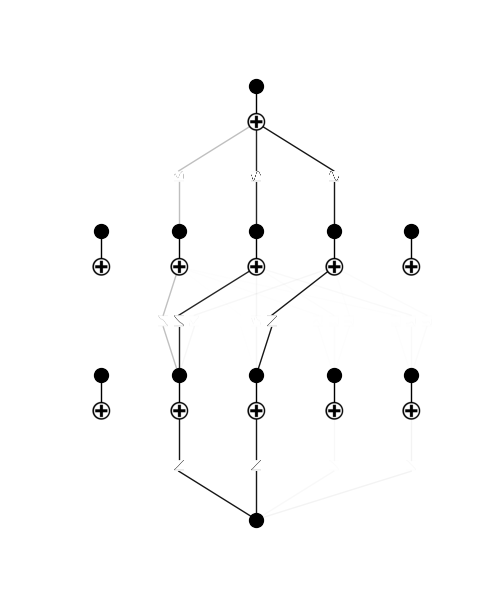

In [3]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
kan_model = MultKAN(
    width=[input_size, hidden_layers, hidden_layers, output_size],
    grid=5, 
    k=3,
    #seed=42, 
    device=device, 
    #grid_range= [interval[0], interval[1]],
    #noise_scale=0.0,
    #affine_trainable=True,
    #grid_eps=0,
)

results = kan_model.fit(
    dataset, 
    opt = "LBFGS", 
    steps = epochs,
    update_grid = True,
    lamb = learning_rate,
    #lamb_l1 = 100,
    #lamb_entropy = 100,
    #lamb_coef = 100,
    #lamb_coefdiff = 100,
    loss_fn = torch.nn.MSELoss()
)
kan_model.plot()

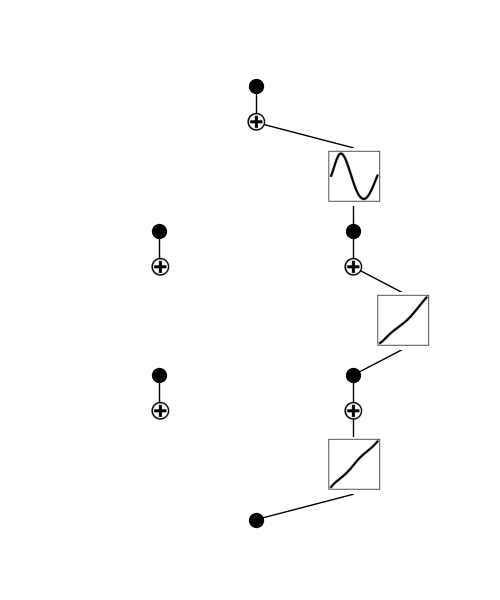

In [4]:
kan_model = kan_model.prune(
    node_th = 1e-1
    #node_th = 0.02,
    #edge_th = 0.06
)
kan_model.fit(
    dataset, 
    opt = "LBFGS", 
    steps = epochs,
    update_grid = True,
    lamb = learning_rate/2,
    #lamb_l1 = 100,
    #lamb_entropy = 100,
    #lamb_coef = 100,
    #lamb_coefdiff = 100,
    loss_fn = torch.nn.MSELoss()
)
kan_model.plot()

In [5]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    kan_model.fix_symbolic(0,0,0,'sin')
    kan_model.fix_symbolic(0,1,0,'x^2')
    kan_model.fix_symbolic(1,0,0,'exp')
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    kan_model.auto_symbolic(
        lib=lib,
        #a_range=(-1,1),
        #b_range=(-1,1),
        r2_threshold=0.9,
    )

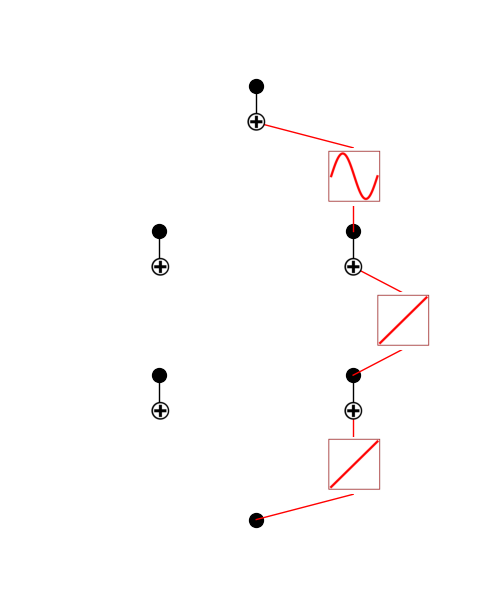

In [6]:
kan_model.fit(
    dataset, 
    opt = "LBFGS", 
    steps = epochs,
    update_grid = True,
    lamb = learning_rate,
    #lamb_l1 = 100,
    #lamb_entropy = 100,
    #lamb_coef = 100,
    #lamb_coefdiff = 100,
    loss_fn = torch.nn.MSELoss()
)
kan_model.plot()

In [7]:
from kan.utils import ex_round
ex_round(kan_model.symbolic_formula()[0][0],4)

0.0067 - 0.9972*sin(1.0002*x_1 + 9.425)

In [8]:
import torch
import torch.nn as nn
import torch.utils.data as td

# Create a dataset and loader for the training data and labels
train_x = dataset['train_input']
train_y = dataset['train_label']
train_ds = td.TensorDataset(train_x,train_y)
print()
train_loader = td.DataLoader(train_ds, batch_size=train_x.shape[0], shuffle=False, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = dataset['test_input']
test_y = dataset['test_label']
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=test_x.shape[0], shuffle=False, num_workers=1)

In [9]:
# Define the neural network
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DNN, self).__init__()
        hidden_size = hidden_size * 20
        self.hidden = nn.Sequential(
            nn.Linear(input_size, hidden_size, device=device),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size, device=device),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size, device=device),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size, device=device)
        )

    def forward(self, x):
        return self.hidden(x)

# Create a model instance from the network
dnn_model = DNN(input_size, hidden_layers, output_size);

In [10]:
# Training function
def train2(model, optimizer, criterion, x_train, y_train, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(x_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')

def train(model, optimizer, criterion, x_train, y_train, num_epochs):
    model.train()

    for epoch in range(num_epochs):
        # LBFGS requires a closure
        def closure():
            optimizer.zero_grad()  # Zero the gradient buffers
            output = model(x_train)
            loss = criterion(output, y_train)
            loss.backward()
            return loss

        # optimizer.step() calls the closure to reevaluate the function
        loss = optimizer.step(closure)

        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')


# Test function
def test(model, x_test):
    model.eval()
    with torch.no_grad():
        predictions = model(x_test)
    return predictions

criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(dnn_model.parameters(), lr=learning_rate)
optimizer = torch.optim.LBFGS(dnn_model.parameters())#, lr=learning_rate))
optimizer.zero_grad()

# Train the model
#train2(dnn_model, optimizer, criterion, train_x, train_y, epochs)
train(dnn_model, optimizer, criterion, train_x, train_y, epochs*10)

# Test the model
predictions = test(dnn_model, test_x)

# Save the model
torch.save(dnn_model.state_dict(), 'dnn_curve_fitting.pth')
print("Model saved as dnn_curve_fitting.pth")

Epoch [0/500], Loss: 0.556758
Epoch [10/500], Loss: 0.018169
Epoch [20/500], Loss: 0.018083
Epoch [30/500], Loss: 0.018034
Epoch [40/500], Loss: 0.018021
Epoch [50/500], Loss: 0.018011
Epoch [60/500], Loss: 0.017995
Epoch [70/500], Loss: 0.017987
Epoch [80/500], Loss: 0.017977
Epoch [90/500], Loss: 0.017973
Epoch [100/500], Loss: 0.017983
Epoch [110/500], Loss: 0.017969
Epoch [120/500], Loss: 0.017965
Epoch [130/500], Loss: 0.017957
Epoch [140/500], Loss: 0.017946
Epoch [150/500], Loss: 0.017890
Epoch [160/500], Loss: 0.017858
Epoch [170/500], Loss: 0.017826
Epoch [180/500], Loss: 0.017791
Epoch [190/500], Loss: 0.017725
Epoch [200/500], Loss: 0.017704
Epoch [210/500], Loss: 0.017697
Epoch [220/500], Loss: 0.017688
Epoch [230/500], Loss: 0.017662
Epoch [240/500], Loss: 0.017615
Epoch [250/500], Loss: 0.017596
Epoch [260/500], Loss: 0.017587
Epoch [270/500], Loss: 0.017570
Epoch [280/500], Loss: 0.017556
Epoch [290/500], Loss: 0.017548
Epoch [300/500], Loss: 0.017525
Epoch [310/500], Lo

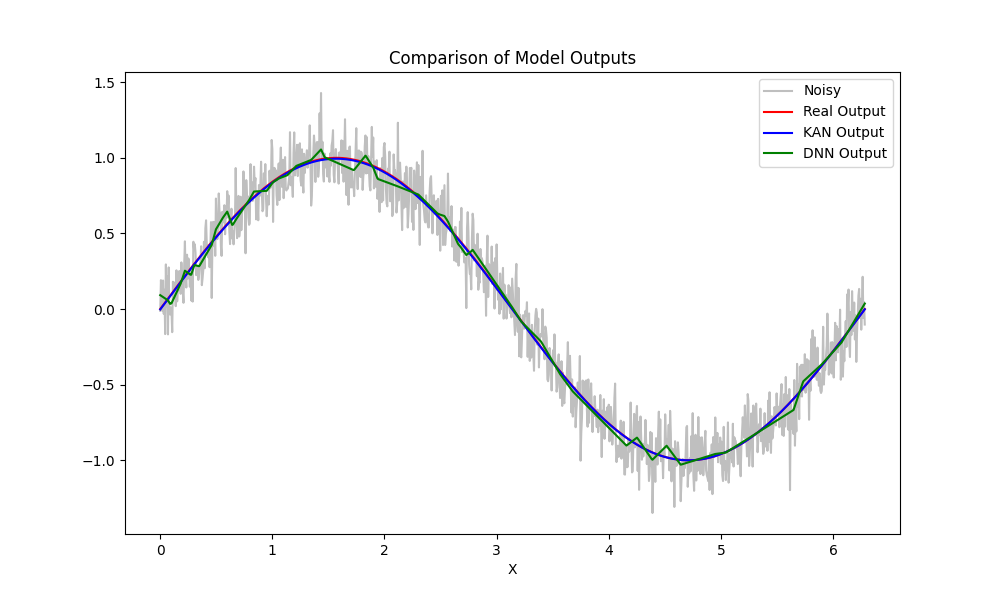

In [15]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Use torch.linspace for direct PyTorch tensor creation
x = torch.linspace(interval[0], interval[1], train_samples)

# Flatten the grid for passing to the model
matr = torch.stack([x.ravel()], dim=-1)
# Get z-values from the function f applied to the grid points
z = f(matr).cpu().numpy()  # Ensure z is computed on GPU and moved to CPU

# Model predictions using the kan_model and dnn_model
knn_output = kan_model(matr).cpu().detach().numpy()
dnn_output = dnn_model(matr).cpu().detach().numpy()

# Plot the outputs from both models
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111)

x = x.cpu().detach().numpy().flatten()

# Plot Model 1 output (red)
ax.plot(x, y.cpu().detach().numpy().flatten(), label='Noisy', color='gray', alpha=0.5)

# Plot Model 1 output (red)
ax.plot(x, z[:,0], label='Real Output', color='red')

# Plot Model 1 output (blue)
ax.plot(x, knn_output.flatten(), label='KAN Output', color='blue')

# Plot Model 2 output (green)
ax.plot(x, dnn_output.flatten(), label='DNN Output', color='green')

# Add labels and title
ax.set_title('Comparison of Model Outputs')
ax.set_xlabel('X')

# Show legend
ax.legend()

# Show the plot
plt.show()

## Cose da notare
- le KAN mantengono la periodicità: al di fuori del range di training seguono il comportamento funzionale => più predicibile
- al contrario le DNN divergono fuori range
- per il fitting del segnale è servita una rete tendenzialmente più piccola => training più leggero
- incrodiando dominio (dei dati) e codominio (della funziona calcolata dalla KAN) posso capire se il risultato è coerente oppure no
    in questo caso il dominio di training è [0, 2$\pi$] e il codominio è (dallo studio di funzione della KAN) [-1,1]
    vedere analisi fatta sul foglio

## Cose da fare
- verificare la robustezza => aumentare il rumore => quanto è resistente?

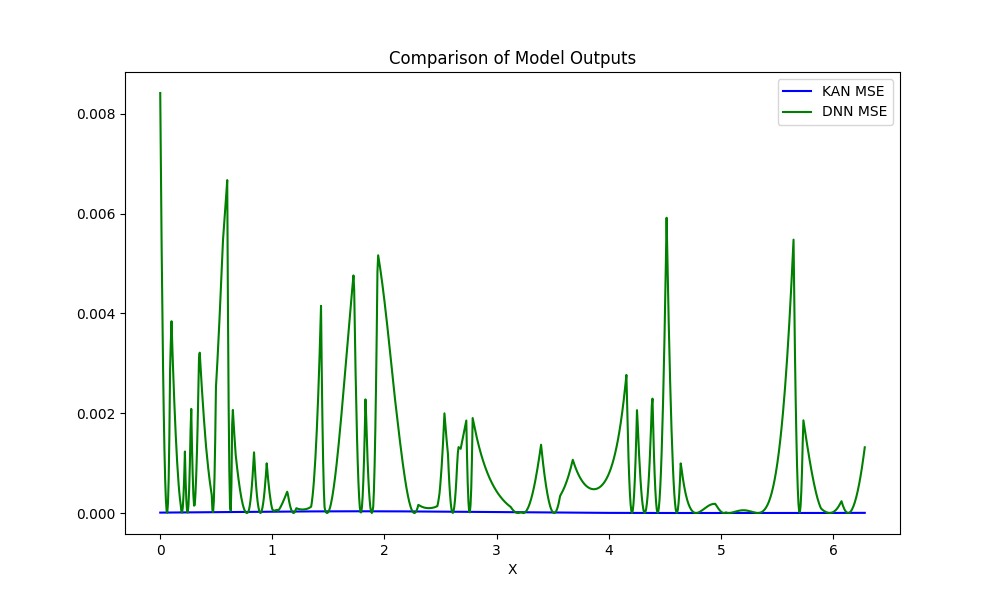

In [12]:
# Define a function to compute the Mean Square Error (MSE)
def mean_square_error(true_func, approx_func):
    return (true_func - approx_func)**2

# Plot the outputs from both models
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111)

# Plot Model 1 output (blue)
ax.plot(x, mean_square_error(z[:,0], knn_output.flatten()), label='KAN MSE', color='blue')

# Plot Model 2 output (green)
ax.plot(x, mean_square_error(z[:,0], dnn_output.flatten()), label='DNN MSE', color='green')

# Add labels and title
ax.set_title('Comparison of Model Outputs')
ax.set_xlabel('X')

# Show legend
ax.legend()

# Show the plot
plt.show()

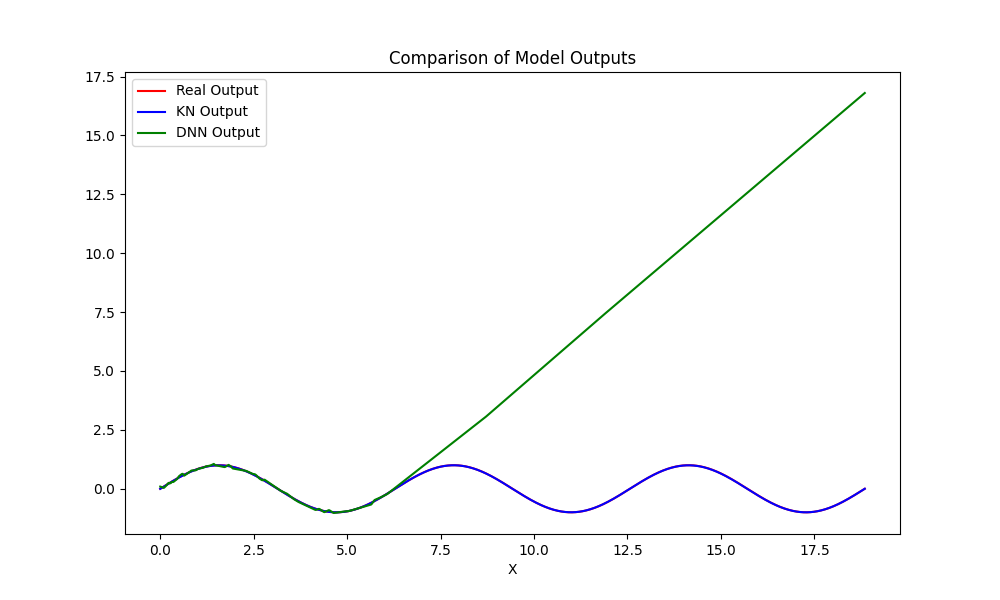

In [13]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Use torch.linspace for direct PyTorch tensor creation
x = torch.linspace(interval[0], 3*interval[1], train_samples)

# Flatten the grid for passing to the model
matr = torch.stack([x.ravel()], dim=-1)
# Get z-values from the function f applied to the grid points
z = f(matr).cpu().numpy()  # Ensure z is computed on GPU and moved to CPU

# Model predictions using the kan_model and dnn_model
knn_output = kan_model(matr).cpu().detach().numpy()
dnn_output = dnn_model(matr).cpu().detach().numpy()

# Plot the outputs from both models
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111)

x = x.cpu().detach().numpy().flatten()

# Plot Model 1 output (red)
#ax.plot(x, y.cpu().detach().numpy().flatten(), label='Noisy', color='gray')

# Plot Model 1 output (red)
ax.plot(x, z[:,0], label='Real Output', color='red')

# Plot Model 1 output (blue)
ax.plot(x, knn_output.flatten(), label='KN Output', color='blue')

# Plot Model 2 output (green)
ax.plot(x, dnn_output.flatten(), label='DNN Output', color='green')

# Add labels and title
ax.set_title('Comparison of Model Outputs')
ax.set_xlabel('X')

# Show legend
ax.legend()

# Show the plot
plt.show()

In [14]:
# Draw DNN model

import torchviz
from torchsummary import summary

summary(dnn_model, input_size=(1000,1))

# Visualize the model structure
def visualize_model(model, input_size=(1000,1)):
    # Generate a sample input tensor
    x = torch.randn(1, *input_size)
    # Use torchviz to make the graph
    dot = torchviz.make_dot(model(x), params=dict(model.named_parameters()))
    return dot

# Generate and save the visualization
dot = visualize_model(dnn_model)
dot.format = 'png'
dot.render('custom_dnn_model')  # This will save as custom_dnn_model.png

print("Model visualization saved as 'custom_dnn_model.png'.")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 1000, 100]             200
              ReLU-2            [-1, 1000, 100]               0
            Linear-3            [-1, 1000, 100]          10,100
              ReLU-4            [-1, 1000, 100]               0
            Linear-5            [-1, 1000, 100]          10,100
              ReLU-6            [-1, 1000, 100]               0
            Linear-7              [-1, 1000, 1]             101
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 4.59
Params size (MB): 0.08
Estimated Total Size (MB): 4.67
----------------------------------------------------------------
Model visualization saved as 'custom_dnn_model.png'.
